In [1]:
import pandas as pd
import numpy as np
from numf.numf import numf
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
from numf.peaks import get_neighbors
from numf.utils import initialize_matrices

np.random.seed(42)

In [2]:
DATA_DIR_PATH = '../data'
SAVED_OUTPUT_PATH = '../saved_output'

In [3]:
def load_saved_models(filepath):
    tmp = np.load(filepath)
    return tmp['W'], tmp['H'], tmp['pouts']

def plot_reg_graphs(M, base_mat, reg_mat):
    W, H = base_mat
    W_reg, H_reg = reg_mat

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    axs[0].plot(M)
    axs[0].plot(W @ H)
    axs[0].plot(W_reg @ H_reg)
    axs[0].legend(['Original', 'No Smoothing', 'Smoothed'])

    for i in range(W.shape[1]):
        axs[1].plot(W[:, i] * H[i, :])
        axs[2].plot(W_reg[:, i] * H_reg[i, :])
    axs[1].set_title('No Smoothing, W * H')
    axs[2].set_title('Smoothed, W * H')


In [4]:
# Run EDA notebook first
df = pd.read_csv(f'{DATA_DIR_PATH}/canada_regional_14d_avg.csv', index_col=0)
df

,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon,total
2020-01-22,0.000000,0.142857,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.428571,0.0,0.000000,0.0,0.000000,0.571429
2020-01-23,0.000000,0.071429,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.428571,0.0,0.000000,0.0,0.000000,0.500000
2020-01-24,0.000000,0.071429,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.428571,0.0,0.000000,0.0,0.000000,0.500000
2020-01-25,0.000000,0.071429,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.428571,0.0,0.000000,0.0,0.000000,0.500000
2020-01-26,0.000000,0.071429,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.428571,0.0,0.000000,0.0,0.000000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-03,109.428571,145.142857,64.000000,125.000000,41.928571,0.0,229.357143,0.0,1777.357143,45.5,923.285714,0.0,2.642857,3463.642857
2022-10-04,109.428571,145.142857,64.000000,125.000000,41.928571,0.0,229.357143,0.0,1777.357143,45.5,956.571429,0.0,2.214286,3496.500000
2022-10-05,109.428571,145.142857,64.000000,125.000000,41.928571,0.0,229.357143,0.0,1812.285714,91.0,958.714286,0.0,2.214286,3579.071429
2022-10-06,0.000000,145.142857,64.000000,164.857143,53.571429,0.0,298.142857,0.0,1812.285714,91.0,928.857143,0.0,2.785714,3560.642857


<AxesSubplot:>

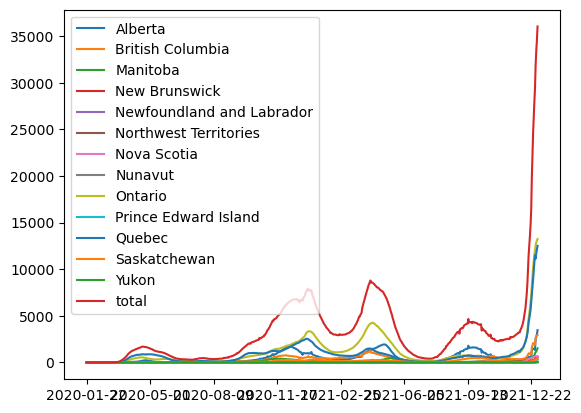

In [5]:
# limiting to 1 January 2022 (close when they stopped testing, source: https://www.npr.org/2022/01/09/1071706554/canadas-covid-testing-crisis)
df = df.loc[: '2022-01-01', :]
df.to_csv(f'{DATA_DIR_PATH}/canada_regional_14d_avg_jan22.csv')
df.plot()

## Splitting dataset

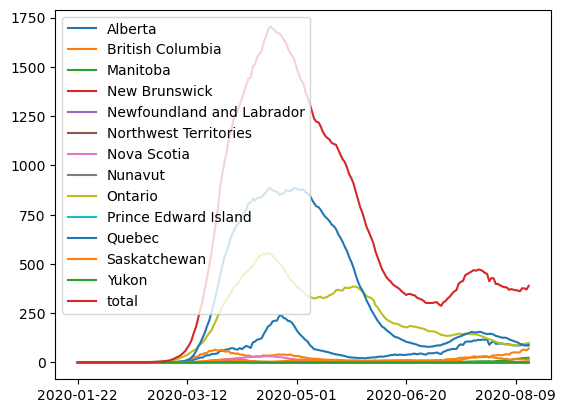

In [6]:
# first split
df.loc[: '2020-08-15', :].plot()
df.loc[: '2020-08-15', :].to_csv(f'{DATA_DIR_PATH}/canada_regional_14d_avg_split1.csv')

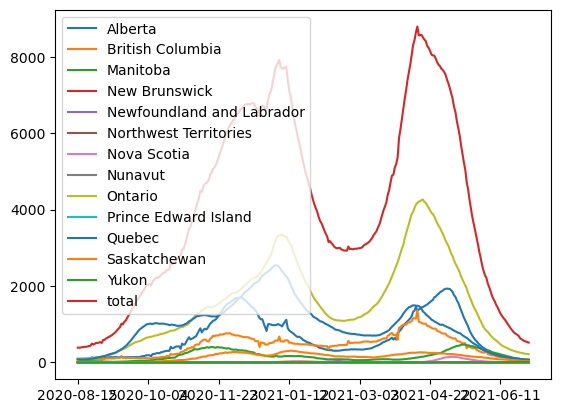

In [7]:
# second split
df.loc['2020-08-15': '2021-07-01', :].plot()
df.loc['2020-08-15': '2021-07-01', :].to_csv(f'{DATA_DIR_PATH}/canada_regional_14d_avg_split2.csv')

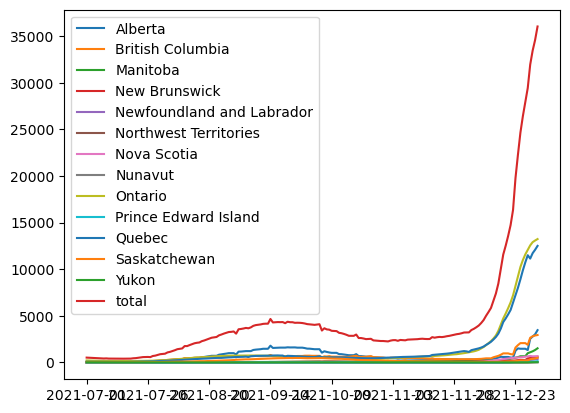

In [8]:
# third split
df.loc['2021-07-01':, :].plot()
df.loc['2021-07-01':, :].to_csv(f'{DATA_DIR_PATH}/canada_regional_14d_avg_split3.csv')

## Running NuMF on split datasets

In [9]:
iters = 200

#### Split 1

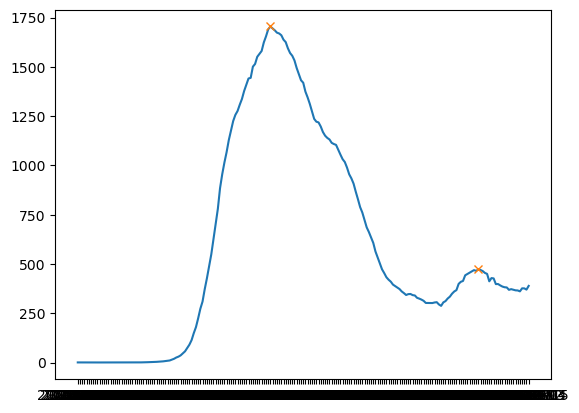

In [10]:
df1 = pd.read_csv(f'{DATA_DIR_PATH}/canada_regional_14d_avg_split1.csv', index_col=0)

# finding peaks
peaks, _ = find_peaks(x=df1['total'], prominence=1, width=6)
plt.plot(df1.index, df1['total'])
plt.plot(df1.index[peaks], df1.loc[df1.index[peaks], ['total']], 'x')

In [11]:
M1 = df1['total'].to_numpy().reshape(-1, 1)
m, n = M1.shape
rank = 2    # note: rank based on number of peaks

# pvals1 = get_neighbors(peaks, m, nrad=3)    # array of points close to peak locations

In [12]:
# No regularization
# W1, H1 = initialize_matrices(m, n, r=rank)
# W1, H1, pouts1 = numf(M1, W1, H1, pvals=pvals1, iters=iters, save_file=f'{SAVED_OUTPUT_PATH}/14day/split1_it{iters}_no_reg.npz')

In [13]:
# With regularization (l2=0.2)
# W1reg, H1reg = initialize_matrices(m, n, r=rank)
# W1reg, H1reg, pouts1_reg = numf(M1, W1reg, H1reg, pvals=pvals1, l2=0.2, iters=iters, save_file=f'{SAVED_OUTPUT_PATH}/14day/split1_it{iters}_reg.npz')

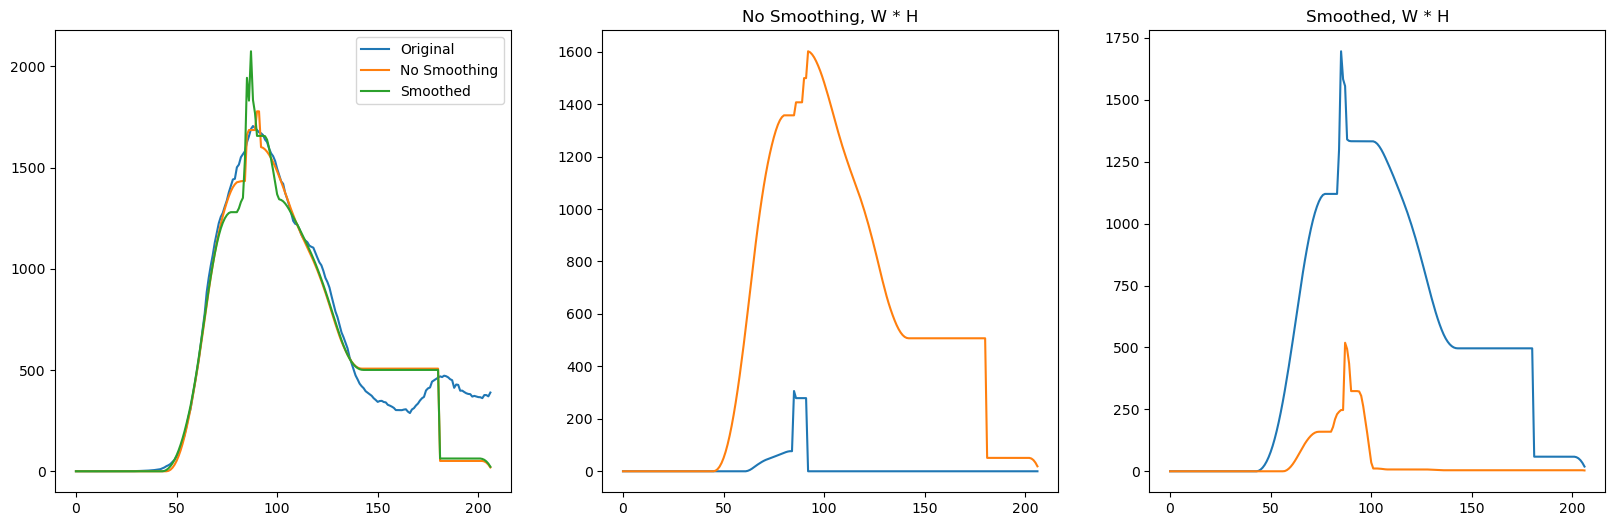

In [14]:
W1, H1, _ = load_saved_models(f'{SAVED_OUTPUT_PATH}/14day/split1_it{iters}_no_reg.npz')
W1reg, H1reg, _ = load_saved_models(f'{SAVED_OUTPUT_PATH}/14day/split1_it{iters}_reg.npz')
plot_reg_graphs(M1, (W1, H1), (W1reg, H1reg))

#### Split 2

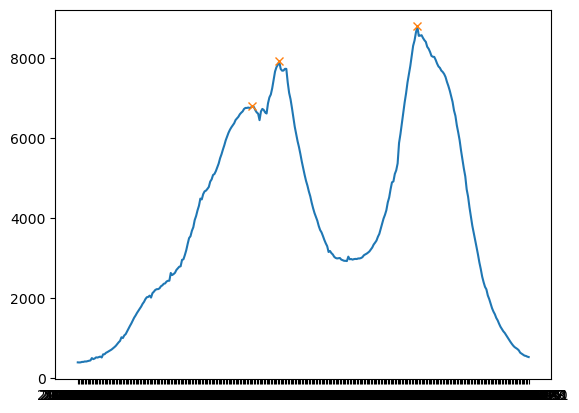

In [15]:
df2 = pd.read_csv(f'{DATA_DIR_PATH}/canada_regional_14d_avg_split2.csv', index_col=0)

# finding peaks
peaks, _ = find_peaks(x=df2['total'], prominence=1, width=6)
plt.plot(df2.index, df2['total'])
plt.plot(df2.index[peaks], df2.loc[df2.index[peaks], ['total']], 'x')

In [16]:
M2 = df2['total'].to_numpy().reshape(-1, 1)
m, n = M2.shape
rank = 3

# pvals2 = get_neighbors(peaks, m, nrad=3)

In [17]:
# No regularization
# W2, H2 = initialize_matrices(m, n, r=rank)
# W2, H2, pouts2 = numf(M2, W2, H2, pvals=pvals2, iters=iters, save_file=f'{SAVED_OUTPUT_PATH}/14day/split2_it{iters}_no_reg.npz')

In [18]:
# With regularization (l2=0.2)
# W2reg, H2reg = initialize_matrices(m, n, r=rank)
# W2reg, H2reg, pouts2_reg = numf(M2, W2reg, H2reg, pvals=pvals2, l2=0.2, iters=iters, save_file=f'{SAVED_OUTPUT_PATH}/14day/split2_it{iters}_reg.npz')

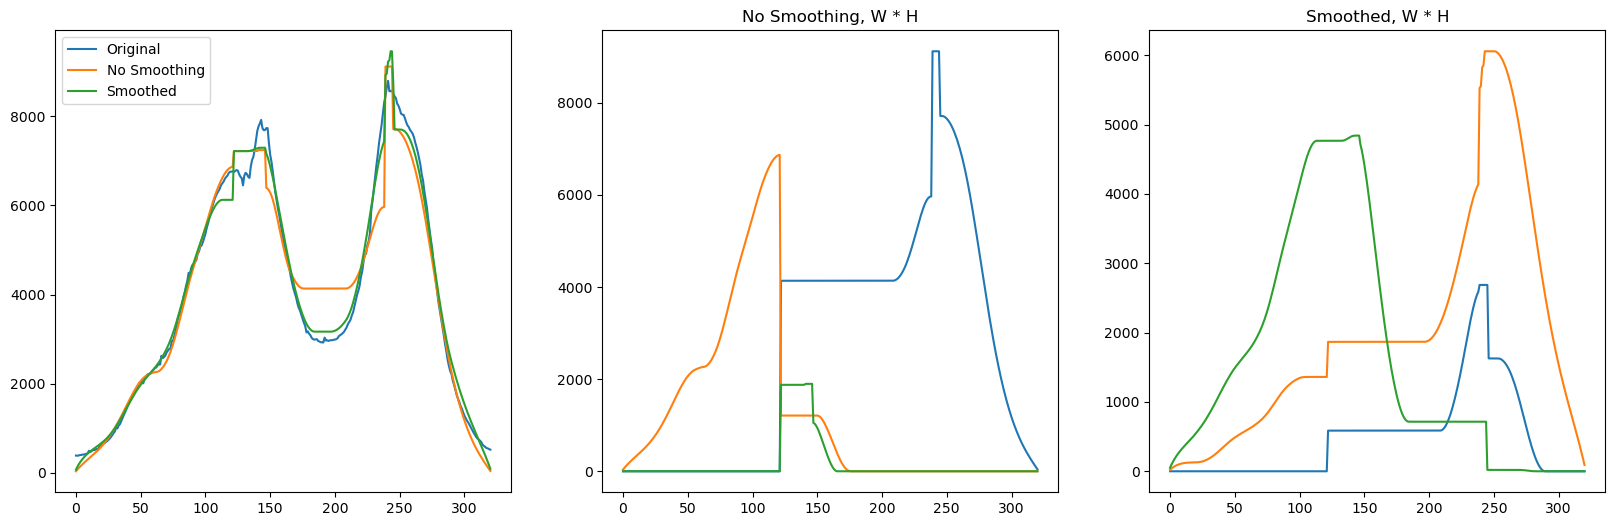

In [19]:
W2, H2, _ = load_saved_models(f'{SAVED_OUTPUT_PATH}/14day/split2_it{iters}_no_reg.npz')
W2reg, H2reg, _ = load_saved_models(f'{SAVED_OUTPUT_PATH}/14day/split2_it{iters}_reg.npz')
plot_reg_graphs(M2, (W2, H2), (W2reg, H2reg))

#### Split 3

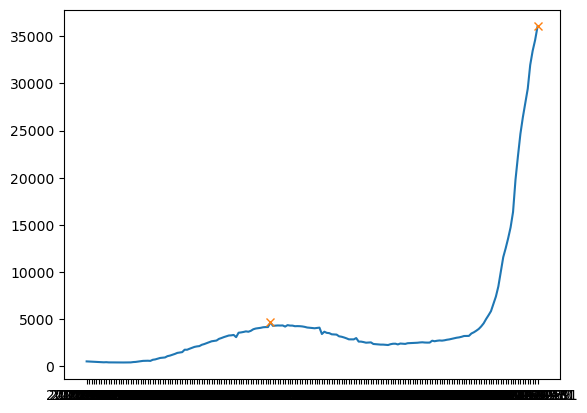

In [20]:
df3 = pd.read_csv(f'{DATA_DIR_PATH}/canada_regional_14d_avg_split3.csv', index_col=0)

# finding peaks
peaks, _ = find_peaks(x=df3['total'], prominence=1, width=6)
peaks = np.append(peaks, [df3.shape[0] - 1])    # adds last index to peak locations
plt.plot(df3.index, df3['total'])
plt.plot(df3.index[peaks], df3.loc[df3.index[peaks], ['total']], 'x')

In [21]:
M3 = df3['total'].to_numpy().reshape(-1, 1)
m, n = M3.shape
rank = 2

# pvals3 = get_neighbors(peaks, m, nrad=3)

In [22]:
# No regularization
# W3, H3 = initialize_matrices(m, n, r=rank)
# W3, H3, pouts3 = numf(M3, W3, H3, pvals=pvals3, iters=iters, save_file=f'{SAVED_OUTPUT_PATH}/14day/split3_it{iters}_no_reg.npz')

In [23]:
# With regularization (l2=0.2)
# W3reg, H3reg = initialize_matrices(m, n, r=rank)
# W3reg, H3reg, pouts3_reg = numf(M3, W3reg, H3reg, pvals=pvals3, l2=0.2, iters=iters, save_file=f'{SAVED_OUTPUT_PATH}/14day/split3_it{iters}_reg.npz')

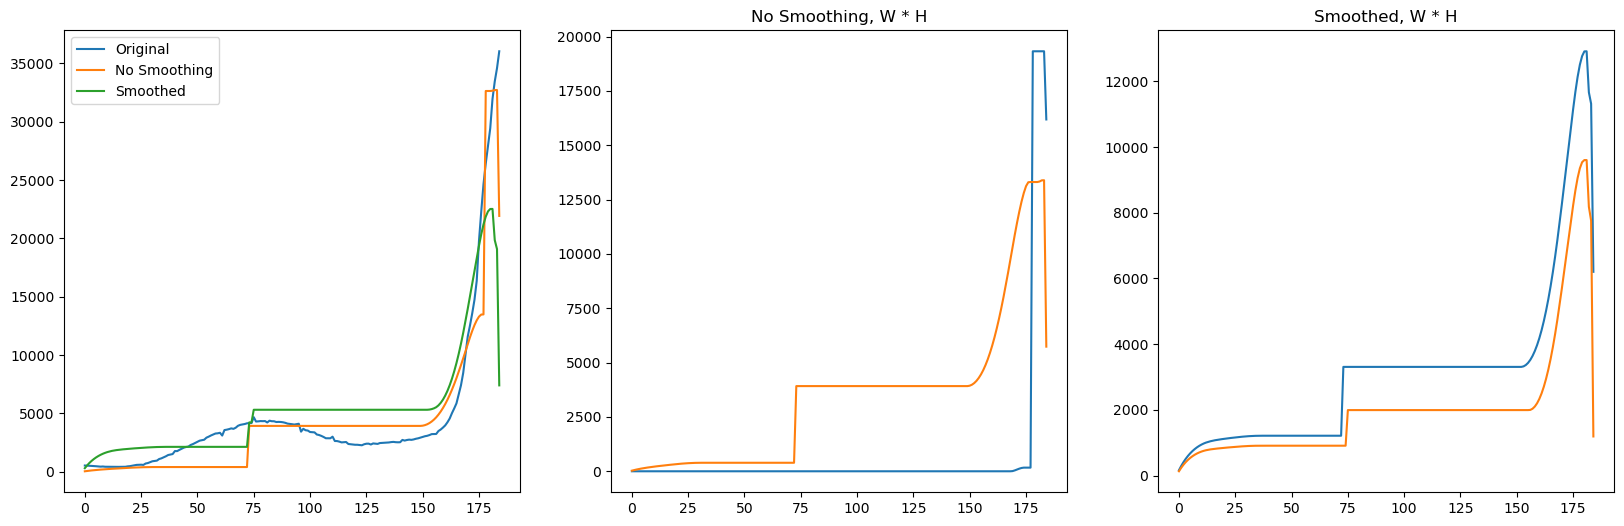

In [24]:
W3, H3, _ = load_saved_models(f'{SAVED_OUTPUT_PATH}/14day/split3_it{iters}_no_reg.npz')
W3reg, H3reg, _ = load_saved_models(f'{SAVED_OUTPUT_PATH}/14day/split3_it{iters}_reg.npz')
plot_reg_graphs(M3, (W3, H3), (W3reg, H3reg))

## On Complete Dataset

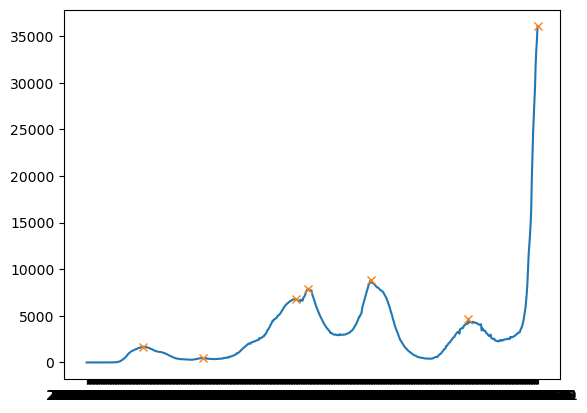

In [25]:
df_comp = pd.read_csv(f'{DATA_DIR_PATH}/canada_regional_14d_avg_jan22.csv', index_col=0)

# finding peaks
peaks, _ = find_peaks(x=df_comp['total'], prominence=1, width=6)
peaks = np.append(peaks, [df_comp.shape[0] - 1])    # adds last index to peak locations
plt.plot(df_comp.index, df_comp['total'])
plt.plot(df_comp.index[peaks], df_comp.loc[df_comp.index[peaks], ['total']], 'x')

In [26]:
M_comp = df_comp['total'].to_numpy().reshape(-1, 1)
m, n = M_comp.shape
rank = 8

# pvals_comp = get_neighbors(peaks, m, nrad=3)

In [27]:
# No regularization
# W_comp, H_comp = initialize_matrices(m, n, r=rank)
# W_comp, H_comp, pouts_comp = numf(M_comp, W_comp, H_comp, pvals=pvals_comp, iters=iters, save_file=f'{SAVED_OUTPUT_PATH}/14day/comp_it{iters}_no_reg.npz')

In [28]:
# With regularization (l2=0.2)
# W_reg, H_reg = initialize_matrices(m, n, r=rank)
# W_reg, H_reg, pouts_reg = numf(M_comp, W_reg, H_reg, pvals=pvals_comp, l2=0.2, iters=iters, save_file=f'{SAVED_OUTPUT_PATH}/14day/comp_it{iters}_no_reg.npz')

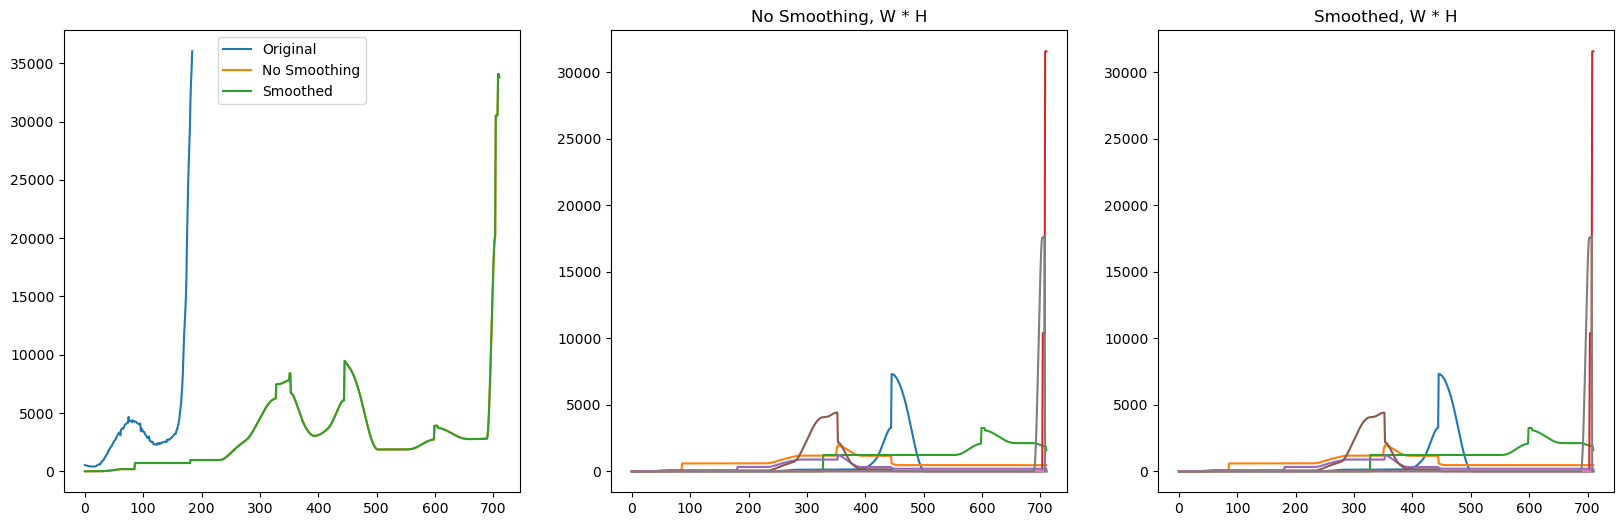

In [29]:
W_comp, H_comp, _ = load_saved_models(f'{SAVED_OUTPUT_PATH}/14day/comp_it{iters}_no_reg.npz')
W_reg, H_reg, _ = load_saved_models(f'{SAVED_OUTPUT_PATH}/14day/comp_it{iters}_no_reg.npz')
plot_reg_graphs(M3, (W_comp, H_comp), (W_reg, H_reg))